In [1]:
url = "http://api.tvmaze.com/singlesearch/shows?q=westworld&embed=episodes"

In [2]:
import requests
import pandas as pd
import json

def tvmaze_data_to_df(api_link: str):
    response = json.loads(requests.get(api_link).text)
    df = pd.json_normalize(response['_embedded']['episodes'])

    # Renaming the columns
    df.rename(columns={'rating.average': 'average rating', 'image.medium':'medium image link', 'image.original':'Original image link'}, inplace=True)

    # Dropping the columns not present in col_list below
    col_list = ['id', 'url', 'name', 'season', 'number', 'type', 'airdate', 'airtime', 'runtime', 
    'average rating', 'summary', 'medium image link', 'Original image link']

    for col in df.columns:
        if col not in col_list:
            df.drop(col, axis=1, inplace=True)

    # Removig the html tags from 'summary' column
    df['summary'] = df['summary'].str.replace(r'<.*?>', '', regex=True)

    # Converting 'airdate' to datetime format
    df['airdate'] = pd.to_datetime(df['airdate'])

    # Converting 'airtime' to 12-hour time format
    df['airtime'] = pd.to_datetime(df['airtime']).dt.strftime('%I:%M %p')

    # Converting the 'runtime' to float
    df['runtime'] = df['runtime'].astype(float)
    
    return df

In [3]:
df = tvmaze_data_to_df(url)

In [4]:
import seaborn as sns

In [5]:
df.head()

,id,url,name,season,number,type,airdate,airtime,runtime,summary,average rating,medium image link,Original image link
0,869671,https://www.tvmaze.com/episodes/869671/westwor...,The Original,1,1,regular,2016-10-02,09:00 PM,68.0,A woman named Dolores is a free spirit in the ...,8.0,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...
1,911201,https://www.tvmaze.com/episodes/911201/westwor...,Chestnut,1,2,regular,2016-10-09,09:00 PM,60.0,Bernard suspects that someone is sabotaging th...,7.7,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...
2,911204,https://www.tvmaze.com/episodes/911204/westwor...,The Stray,1,3,regular,2016-10-16,09:00 PM,60.0,Bernard continues to investigate Dolores' supp...,7.6,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...
3,911205,https://www.tvmaze.com/episodes/911205/westwor...,Dissonance Theory,1,4,regular,2016-10-23,09:00 PM,60.0,While Dolores joins William and Logan on their...,7.9,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...
4,927174,https://www.tvmaze.com/episodes/927174/westwor...,Contrapasso,1,5,regular,2016-10-30,09:00 PM,60.0,Dolores takes the first step on her path of di...,8.0,https://static.tvmaze.com/uploads/images/mediu...,https://static.tvmaze.com/uploads/images/origi...


### Get all the overall ratings for each season and using plots compare the ratings for all the seasons, like season 1 ratings, season 2, and so on.

In [6]:
df['season_'] = df['season']
temp = df.groupby('season_').mean() [['season', 'average rating']]
df.drop(columns=['season_'], inplace=True)
temp

,season,average rating
season_,,
1,1.0,8.0900
2,2.0,8.0000
3,3.0,7.7750
4,4.0,7.5375


<Axes: xlabel='season', ylabel='average rating'>

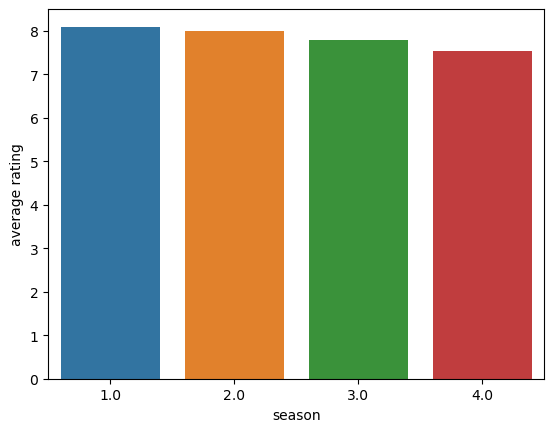

In [7]:
sns.barplot(data=temp, x='season', y='average rating')

### Get all the episode names, whose average rating is more than 8 for every season

<Axes: xlabel='average rating', ylabel='name'>

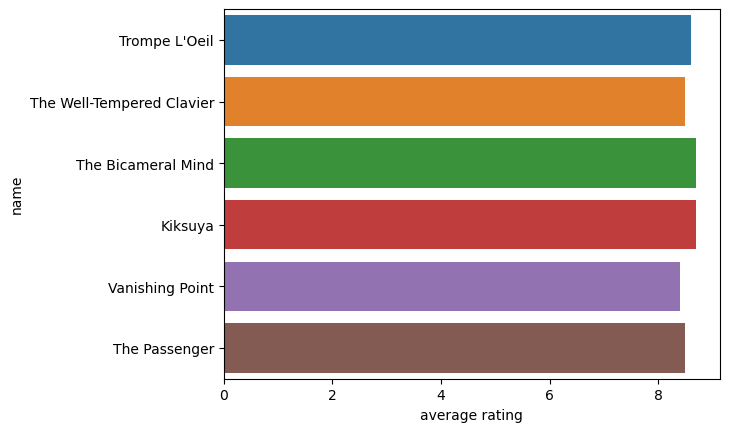

In [8]:
temp_df_1 = df[df['average rating'] > 8] [['name', 'average rating']]
temp_df_1.reset_index(drop=True)

sns.barplot(data = temp_df_1, y='name', x='average rating')

### Get all the episode names that aired before May 2019

In [9]:
df[df['airdate']<pd.Timestamp(2019, 5, 1)][['name', 'airdate']]

,name,airdate
0,The Original,2016-10-02
1,Chestnut,2016-10-09
2,The Stray,2016-10-16
3,Dissonance Theory,2016-10-23
4,Contrapasso,2016-10-30
5,The Adversary,2016-11-06
6,Trompe L'Oeil,2016-11-13
7,Trace Decay,2016-11-20
8,The Well-Tempered Clavier,2016-11-27
9,The Bicameral Mind,2016-12-04


### Get the episode name from each season with the highest and lowest rating

In [10]:
# Checking the minimum and maximum rating in each season

df.groupby('season').agg({'average rating': ['min', 'max']})

average rating     
                  min  max
season                    
1                 7.6  8.7
2                 7.6  8.7
3                 7.5  8.0
4                 7.1  7.8

In [12]:
# Adding a minimum rating column for each season's minimum rating

df['min_rating'] = df.groupby('season')['average rating'].transform(lambda x: x.min())

# Comparing average rating with min_rating
df[df['average rating'] == df['min_rating']].reset_index() [['season', 'name', 'average rating']]

,season,name,average rating
0,1,The Stray,7.6
1,2,Akane No Mai,7.6
2,3,Decoherence,7.5
3,3,Passed Pawn,7.5
4,4,The Auguries,7.1


In [13]:
# Adding a maximum rating column for each season's maximum rating

df['max_rating'] = df.groupby('season')['average rating'].transform(lambda x: x.max())

# Comparing average rating with max_rating
df[df['average rating'] == df['max_rating']].reset_index() [['season', 'name', 'average rating']]

,season,name,average rating
0,1,The Bicameral Mind,8.7
1,2,Kiksuya,8.7
2,3,Parce Domine,8.0
3,3,The Mother of Exiles,8.0
4,4,Zhuangzi,7.8


### Get the summary for the most popular ( ratings ) episode in every season

In [14]:
df[df['average rating'] == df['max_rating']].reset_index() [['season', 'average rating', 'summary']]

,season,average rating,summary
0,1,8.7,Delores finds out the truth about William's fa...
1,2,8.7,Another of Westworld's Host revolutionaries is...
2,3,8.0,"If you're stuck in a loop, try walking in a st..."
3,3,8.0,The truth doesn't always set you free.
4,4,7.8,God is bored.
